<a href="https://colab.research.google.com/github/OKEunsu/Data-Science/blob/main/OPENCV/6.Karas__tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [25]:
import tensorflow as tf
from tensorflow import keras

import IPython
import matplotlib.pyplot as plt

In [11]:
!pip install -q -U keras-tuner
import kerastuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.4 MB/s eta 0:00:00


<ipython-input-11-5d7b6944a6ac>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Data

In [5]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [13]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

In [14]:
len(img_train), len(img_test)

(60000, 10000)

In [15]:
def model_builder(hp):
  model = keras.Sequential() # 모델 생성
  model.add(keras.layers.Flatten(input_shape=(28, 28))) # Flatten 레이어 추가 2D -> 1D

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu')) # 튜닝 units 하이퍼파라미터 32->512 32의 간격으로 튜닝
  model.add(keras.layers.Dense(10)) # 출력 레이어 10

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                metrics = ['accuracy'])

  return model

In [16]:
tuner = kt.Hpyerband(model_builder, # 하이퍼파라미터 설정한 모델 함수 가져오기
											objective = 'val_accuracy', # 검증 데이터셋의 정확도 목표
											max_epochs = 10, # 10번 동안 반복
											factor = 3, # 하이퍼밴드 알고리즘이 에포크 수를 조정할 때 쓰는 인자
																	# 매 반복 마다 3배씩 늘려가며 탐색
											directory = 'my_dir', # my_dir에 결과값 저장
											project_name = 'theFirstKT') # 튜닝프로젝트의 이름

In [17]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [18]:
# 최적의 하이퍼파라미터 찾기 : best_hps
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 01m 23s]
val_accuracy: 0.8741000294685364

Best val_accuracy So Far: 0.8784000277519226
Total elapsed time: 00h 16m 27s


In [19]:
best_hps

# 최적의 하이퍼파라미터로 model 생성

In [20]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 480)               376800    
                                                                 
 dense_3 (Dense)             (None, 10)                4810      
                                                                 
Total params: 381610 (1.46 MB)
Trainable params: 381610 (1.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs = 10, validation_data = (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5604 - accuracy: 0.7942 - val_loss: 0.4555 - val_accuracy: 0.8350
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4116 - accuracy: 0.8494 - val_loss: 0.4082 - val_accuracy: 0.8525
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3717 - accuracy: 0.8641 - val_loss: 0.4205 - val_accuracy: 0.8479
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3454 - accuracy: 0.8742 - val_loss: 0.3823 - val_accuracy: 0.8615
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3287 - accuracy: 0.8783 - val_loss: 0.4148 - val_accuracy: 0.8481
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3136 - accuracy: 0.8830 - val_loss: 0.3645 - val_accuracy: 0.8687
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2996 - accuracy: 0.8897 - val_loss: 0.3552 - val_accuracy:

In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

# 결과 시각화

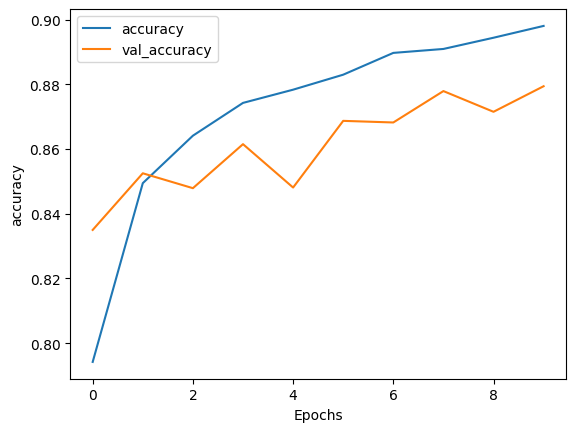

In [23]:
plot_graphs(history, 'accuracy')

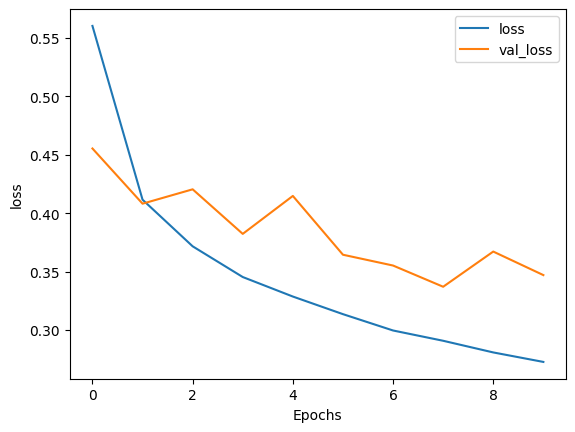

In [24]:
plot_graphs(history, 'loss')